In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import io, color, exposure
import skimage

from pathlib import Path
import os, sys

from dask import bag, diagnostics


sys.path.insert(0, str(Path.cwd().parent))
import leukopy_lib as leuko
from importlib import reload
reload(leuko)

<module 'leukopy_lib' from '/home/marie-anne/code/Leukopy/notebooks/leukopy_lib.py'>

## Import normal peripheral blood cell dataset

### Sort labels
Segmented neutrophils are fully mature and can be merge with the category 'Neutrophil'. (label, 11 classes)


Most immature neutrophils (IG) as metamyelocytes, myelocytes and promyelocytes are difficult to differentiate and their separation are prone to debate. (9 classes, label_3)


Band neutrophils are also immature.(8 classes, label_2)




In [71]:
#get path to data/main_dir
path_name = '../../data/PBC_dataset_normal_Barcelona'
path = Path(path_name)

In [72]:
df = leuko.generate_images_df(path_name)
df.head()

,img_path,cell_type,label,label_2,label_3
0,../../data/PBC_dataset_normal_Barcelona/monocy...,monocyte,MO,MO,MO
1,../../data/PBC_dataset_normal_Barcelona/monocy...,monocyte,MO,MO,MO
2,../../data/PBC_dataset_normal_Barcelona/monocy...,monocyte,MO,MO,MO
3,../../data/PBC_dataset_normal_Barcelona/monocy...,monocyte,MO,MO,MO
4,../../data/PBC_dataset_normal_Barcelona/monocy...,monocyte,MO,MO,MO


In [73]:
df.iloc[:, 1:].nunique()

cell_type     8
label        11
label_2       8
label_3       9
dtype: int64

<AxesSubplot:xlabel='label', ylabel='count'>

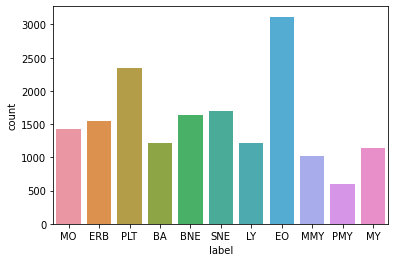

In [74]:
sns.countplot(x=df.label)

### Import images with dask

### Add height, width, brightness, luminance to df

In [75]:
df.img_path.to_list()[-1]

'../../data/PBC_dataset_normal_Barcelona/ig/MMY_244097.jpg'

In [76]:
tst = io.imread(df.img_path.to_list()[-1])
tst.shape[0] 

363

In [77]:
def add_columns(filename):
    
    im = io.imread(filename)
    temp = pd.DataFrame(index=[0])

    temp['height'] = im.shape[0] 
    temp['width'] = im.shape[1]
    temp['mean_brightness'] = np.mean(im)    
    
    im_gray = color.rgb2grey(im)
    temp['mean_luminance'] = np.mean(im_gray)
    
    return temp

In [78]:
addcol_bag = bag.from_sequence(df.img_path.to_list()).map(add_columns)
with diagnostics.ProgressBar():
    res = addcol_bag.compute()

[########################################] | 100% Completed | 30.7s


In [79]:
df.shape

(16941, 5)

In [80]:
len(res)

16941

In [81]:
res_df = pd.concat(res).reset_index(drop=True)
df_temp = df.join(res_df)
df_temp

,img_path,cell_type,label,label_2,label_3,height,width,mean_brightness,mean_luminance
0,../../data/PBC_dataset_normal_Barcelona/monocy...,monocyte,MO,MO,MO,363,360,196.225564,0.756902
1,../../data/PBC_dataset_normal_Barcelona/monocy...,monocyte,MO,MO,MO,363,360,196.672727,0.757366
2,../../data/PBC_dataset_normal_Barcelona/monocy...,monocyte,MO,MO,MO,363,360,204.348235,0.797640
3,../../data/PBC_dataset_normal_Barcelona/monocy...,monocyte,MO,MO,MO,363,360,199.038259,0.770929
4,../../data/PBC_dataset_normal_Barcelona/monocy...,monocyte,MO,MO,MO,363,360,191.020018,0.734784
...,...,...,...,...,...,...,...,...,...
16936,../../data/PBC_dataset_normal_Barcelona/ig/PMY...,ig,PMY,IG,IG,363,360,190.868100,0.729896
16937,../../data/PBC_dataset_normal_Barcelona/ig/MY_...,ig,MY,IG,IG,363,360,198.083540,0.769725
16938,../../data/PBC_dataset_normal_Barcelona/ig/MY_...,ig,MY,IG,IG,363,360,202.367218,0.791640
16939,../../data/PBC_dataset_normal_Barcelona/ig/PMY...,ig,PMY,IG,IG,363,360,190.455229,0.731147


In [82]:
df_temp.to_csv('../../data/PBC_dataset_normal_df.csv', index=False)

In [83]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16941 entries, 0 to 16940
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   img_path         16941 non-null  object 
 1   cell_type        16941 non-null  object 
 2   label            16941 non-null  object 
 3   label_2          16941 non-null  object 
 4   label_3          16941 non-null  object 
 5   height           16941 non-null  int64  
 6   width            16941 non-null  int64  
 7   mean_brightness  16941 non-null  float64
 8   mean_luminance   16941 non-null  float64
dtypes: float64(2), int64(2), object(5)
memory usage: 1.2+ MB


In [84]:
df_temp.to_pickle('../../data/PBC_dataset_normal_df.pkl')